In [47]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

In [48]:
df_path = '../../data/whisper-small-runs.csv'
df = pd.read_csv(df_path)
df.head()

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4


In [49]:
df['experiment_name'].unique()

array(['whisper-small-tira', 'whisper-small-tira-all',
       'whisper-small-tira-all-clean',
       'whisper-small-tira-all-clean-lid-alpha-0.2',
       'whisper-small-tira-all-ewc-lambda-1',
       'whisper-small-tira-all-lid-alpha-0.2',
       'whisper-small-tira-all-lid-alpha-0.2-ewc-lambda-1',
       'whisper-small-tira-eng', 'whisper-small-tira-eng-cs',
       'whisper-small-tira-eng-cs-20-80-large',
       'whisper-small-tira-eng-cs-20-80-large-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-large-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-20-80-small',
       'whisper-small-tira-eng-cs-20-80-small-ewc-lambda-1',
       'whisper-small-tira-eng-cs-20-80-small-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-50-50',
       'whisper-small-tira-eng-cs-50-50-ewc-lambda-1',
       'whisper-small-tira-eng-cs-50-50-lid-alpha-0.2',
       'whisper-small-tira-eng-cs-clean',
       'whisper-small-tira-eng-cs-clean-ewc-lambda-1',
       'whisper-small-tira-eng-cs-clean-lid-al

In [50]:
# get more detailed colnames
get_metric = lambda s: 'cer' if s.endswith('cer') else 'wer' if s.endswith('wer') else ''
df['metric']=df['tag'].apply(get_metric)
df['metric'].value_counts()

metric
       9056
cer    1407
wer    1407
Name: count, dtype: int64

In [51]:
df

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11865,NaN,6288,eval_steps_per_second,0.049000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,6,
11866,NaN,7336,eval_steps_per_second,0.038000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,7,
11867,NaN,8384,eval_steps_per_second,0.172000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,8,
11868,NaN,9432,eval_steps_per_second,0.034000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,9,


In [52]:
df['epoch']=0
epoch_mask = df['tag'].str.contains('epoch')
for i, row in df[epoch_mask].iterrows():
    step_mask = df['step']==row['step']
    exp_mask = df['experiment_name']==row['experiment_name']
    df.loc[step_mask & exp_mask, 'epoch'] = int(row['value'])
df

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,lang_prompt,train_lang_token,embedding_distance_regularization_type,distance_regularization_lambda,ewc_lambda,lm_beta,lm_alpha,beam,epoch,metric
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,0,cer
1,1.0,1341,eval/tira_eval-en+sw_cer,0.736247,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,1,cer
2,2.0,2682,eval/tira_eval-en+sw_cer,0.692670,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,2,cer
3,3.0,4023,eval/tira_eval-en+sw_cer,0.765299,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,3,cer
4,4.0,5364,eval/tira_eval-en+sw_cer,0.819973,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,NaN,False,-1,False,NaN,NaN,NaN,NaN,NaN,NaN,4,cer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11865,NaN,6288,eval_steps_per_second,0.049000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,6,
11866,NaN,7336,eval_steps_per_second,0.038000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,7,
11867,NaN,8384,eval_steps_per_second,0.172000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,8,
11868,NaN,9432,eval_steps_per_second,0.034000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,NaN,False,-1,False,NaN,NaN,1.0,NaN,0.5,2.0,9,


In [53]:
unique_datasets = ['fl_en', 'HH20210312', 'HH20210913', 'tira-clean-split', 'sasoc-cs', 'sasoc-zul', 'sasoc-en', 'nchlt_zul', 'nchlt_eng', 'tira_cs']

def get_dataset(s):
    for dataset in unique_datasets:
        if dataset in s:
            return dataset


df['dataset']=df['tag'].apply(get_dataset)
df['dataset'].value_counts()

dataset
sasoc-cs     2256
fl_en        2052
nchlt_zul    1572
Name: count, dtype: int64

In [54]:
# so we can compare no LID loss to using LID loss
df['lid_loss_alpha']=df['lid_loss_alpha'].fillna(0)
df['ewc_lambda']=df['ewc_lambda'].fillna(0)

In [55]:
df['ewc']=df['ewc_lambda']>0
df['lid_loss']=df['lid_loss_alpha']>0
df['regularization']='none'
df.loc[df['ewc'], 'regularization']='ewc'
df.loc[df['lid_loss'], 'regularization']='lid_loss'
df.loc[df['ewc'] & df['lid_loss'], 'regularization']='ewc+lid_loss'

In [77]:
df['train_data']='tira'
df.loc[df['experiment_name'].str.contains('tira-eng'), 'train_data']='tira-eng'
df.loc[df['experiment_name'].str.contains('tira-eng-50pct'), 'train_data']='tira-eng-50pct'
df.loc[df['experiment_name'].str.contains('tira-eng-cs'), 'train_data']='misc'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-small'), 'train_data']='tira-eng-cs-20-80-small'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-20-80-large'), 'train_data']='tira-eng-cs-20-80-large'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-50-50-large'), 'train_data']='tira-eng-cs-50-50'
df.loc[df['experiment_name'].str.contains('tira-eng-cs-clean'), 'train_data']='tira-eng-cs-clean'
df.loc[df['experiment_name'].str.contains('tira-all'), 'train_data']='tira-all'
df.loc[df['experiment_name'].str.contains('tira-all-clean'), 'train_data']='tira-all-clean'
df.loc[df['experiment_name'].str.contains('tira-all-long'), 'train_data']='tira-all-long'

df.loc[df['experiment_name'].str.contains('zulu'), 'train_data']='zulu'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng'), 'train_data']='zulu+eng'
df.loc[df['experiment_name'].str.contains('zulu-swahili-eng-50pct'), 'train_data']='zulu+eng-50pct'
df.loc[df['experiment_name'].str.contains('zulu-eng-cs'), 'train_data']='zulu-eng-cs'
df.loc[df['experiment_name'].str.contains('zulu-eng-all'), 'train_data']='zulu-eng-all'

df['train_data'].value_counts()

train_data
zulu-eng-cs                2680
zulu+eng                   2476
zulu                       2072
tira-all                    808
misc                        742
zulu-eng-all                705
tira                        611
tira-eng                    534
tira-all-clean              364
tira-eng-cs-20-80-large     318
tira-eng-cs-20-80-small     270
tira-eng-cs-clean           258
zulu+eng-50pct               32
Name: count, dtype: int64

In [58]:
df.loc[
    df['experiment_name'].str.contains('tira')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'tira-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     2256
fl_en        2052
tira-cs      1974
nchlt_zul    1572
Name: count, dtype: int64

In [59]:
df.loc[
    (df['train_data']=='zulu-eng-all')&df['tag'].str.contains('eval')&df['dataset'].isna(),
    'dataset'
] = 'sasoc-cs'
df['dataset'].value_counts()

dataset
sasoc-cs     2736
fl_en        2052
tira-cs      1974
nchlt_zul    1572
Name: count, dtype: int64

In [60]:
df=df.sort_values('step')
for experiment in df['experiment_name'].unique():
    for tag in df['tag'].unique():
        if 'loss' not in tag:
            continue
        loss_mask = df['tag']==tag
        experiment_mask = df['experiment_name']==experiment
        loss_diff = np.diff(df.loc[experiment_mask&loss_mask, 'value'])
        loss_diff = np.insert(loss_diff, 0, 0)
        df.loc[experiment_mask&loss_mask, 'loss_diff']=loss_diff
df.head()


,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
0,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira,1900-02-09 04:05:01,NaN,NaN,0.0,False,...,NaN,NaN,0,cer,tira-cs,False,False,none,tira,NaN
2496,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira-eng-cs-clean,1900-02-10 03:26:40,NaN,NaN,0.0,False,...,NaN,NaN,0,cer,tira-cs,False,False,none,tira-eng-cs-clean,NaN
2507,11.0,0,eval/tira_eval-en+sw_loss,1.923962,whisper-small-tira-eng-cs-clean,1900-02-10 03:26:40,NaN,NaN,0.0,False,...,NaN,NaN,0,,tira-cs,False,False,none,tira-eng-cs-clean,0.0
2518,22.0,0,eval/tira_eval-en+sw_runtime,18.551800,whisper-small-tira-eng-cs-clean,1900-02-10 03:26:40,NaN,NaN,0.0,False,...,NaN,NaN,0,,tira-cs,False,False,none,tira-eng-cs-clean,NaN
2529,33.0,0,eval/tira_eval-en+sw_samples_per_second,4.258000,whisper-small-tira-eng-cs-clean,1900-02-10 03:26:40,NaN,NaN,0.0,False,...,NaN,NaN,0,,tira-cs,False,False,none,tira-eng-cs-clean,NaN


# EWC

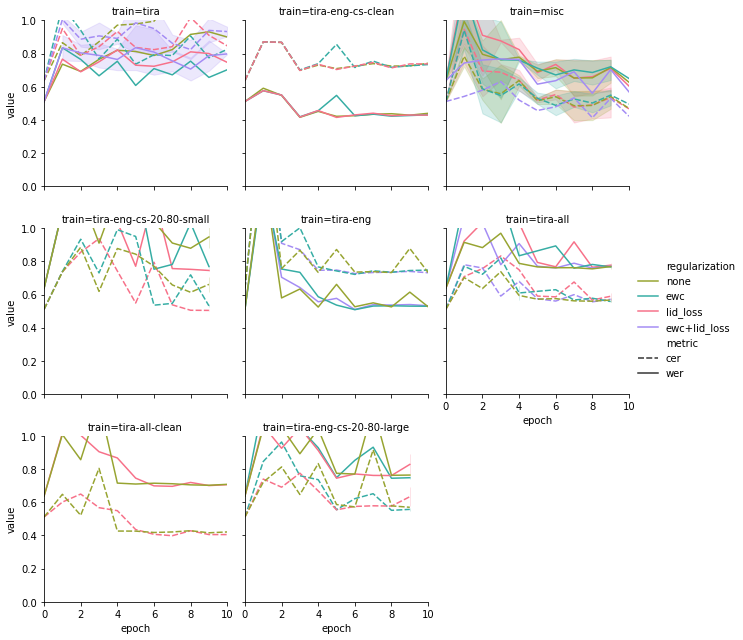

In [79]:
df['beam']=df['beam'].fillna(0).astype(float)
df['lm_alpha']=df['lm_alpha'].astype(str)
g = sb.FacetGrid(
    df[
        # (df['experiment_name'].str.contains('zulu')) &
        # ~(df['experiment_name'].str.contains('zulu-swahili-eng')) &
        (df['experiment_name'].str.contains('tira')) &
        # (df['lang_prompt']=='swahili') &
        # (df['lang_prompt']=='croatian')&
        # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
        (df['dataset'].isin(['sasoc-cs', 'tira-cs'])) &
        (df['ewc_lambda'].isin([0,1])) &
        (df['lid_loss_alpha'].isin([0,0.2])) &
        # (df['beam']==2)&
        (df['beam']==0)&
        # (df['regularization']=='none')&
        # (df['tag'].str.contains('loss'))
        # (df['tag']=='train/loss')
        (df['metric']!='')
        # (df['LoRA'])
    ],
    # col='ewc_lambda',
    col='train_data',
    col_wrap=3,
    # row='lm_alpha',
    # col='lid_loss_alpha',
    # row='beam',
    # row='dataset',
    # sharey=False,
)
palette_map= {
    key: color for key, color in
    zip(['lid_loss', 'none', 'ewc', 'ewc+lid_loss'], sb.color_palette('husl',4))
}
g.map_dataframe(
    sb.lineplot,
    x='epoch',
    # x='step',
    y='value',
    # y='loss_diff',
    # hue='lid_loss_alpha',
    hue='regularization',
    palette=palette_map,
    # hue='ewc_lambda',
    # errorbar=None,
    legend='full',
    style='metric',
    # style='tag',
)
# g.set_titles('eval={row_name}, train={col_name}')
g.set_titles('train={col_name}')
g.add_legend()
# g.set_title('Performance on English while decoding as Yoruba')
g.set(ylim=(0,1))
g.set(xlim=(0,10))
plt.show()

In [ ]:
df.loc[
    (df['train_data']=='zulu+eng')&
    (df['regularization']=='ewc+lid_loss')&
    (df['epoch']==1)&
    (df['metric']=='wer')
]

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
8208,21.0,349,eval/sasoc-cs-en+sw_wer,0.793103,whisper-small-zulu-swahili-eng-50pct-lid-alpha...,1900-02-11 22:03:10,NaN,NaN,0.2,False,...,nan,0.0,1,wer,sasoc-cs,True,True,ewc+lid_loss,zulu+eng,NaN
9634,122.0,699,eval/sasoc-cs-en+sw_wer,1.536398,whisper-small-zulu-swahili-eng-lid-alpha-0.2-e...,1900-02-02 15:52:38,NaN,NaN,0.2,False,...,nan,0.0,1,wer,sasoc-cs,True,True,ewc+lid_loss,zulu+eng,NaN


In [63]:
df.loc[(df['train_data']=='zulu')&(df['regularization']=='none')&(df['epoch']==1)&(df['dataset']=='sasoc-cs')&(df['metric']=='wer')]

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
7257,122.0,546,eval/sasoc-cs-en+sw_wer,1.212005,whisper-small-zulu-swahili,1900-01-27 18:10:55,NaN,NaN,0.0,False,...,nan,0.0,1,wer,sasoc-cs,False,False,none,zulu,NaN


In [64]:
df[df['beam']>0]

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
11700,NaN,1048,eval_runtime,621.641500,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,...,0.5,2.0,1,,sasoc-cs,False,False,none,zulu-eng-all,NaN
11730,NaN,1048,eval_loss,5.006366,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2,0.0,False,...,nan,2.0,1,,sasoc-cs,False,False,none,zulu-eng-all,0.0
11790,NaN,1048,eval_steps_per_second,0.130000,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2,0.0,False,...,nan,2.0,1,,sasoc-cs,False,False,none,zulu-eng-all,NaN
11740,NaN,1048,eval_model_preparation_time,0.002300,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2,0.0,False,...,nan,2.0,1,,sasoc-cs,False,False,none,zulu-eng-all,NaN
11720,NaN,1048,eval_steps_per_second,0.045000,whisper-small-zulu-eng-all,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all/beam-2-lm-alpha-0.5,0.0,False,...,0.5,2.0,1,,sasoc-cs,False,False,none,zulu-eng-all,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11829,NaN,10480,eval_wer,0.768838,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,...,0.5,2.0,10,wer,sasoc-cs,True,False,ewc,zulu-eng-all,NaN
11819,NaN,10480,eval_model_preparation_time,0.002400,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,...,0.5,2.0,10,,sasoc-cs,True,False,ewc,zulu-eng-all,NaN
11839,NaN,10480,eval_cer,0.998004,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,...,0.5,2.0,10,cer,sasoc-cs,True,False,ewc,zulu-eng-all,NaN
11849,NaN,10480,eval_runtime,842.376000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,...,0.5,2.0,10,,sasoc-cs,True,False,ewc,zulu-eng-all,NaN


In [65]:
df.sort_values('date', ascending=False)

,index,step,tag,value,experiment_name,date,checkpoint,csv_name,lid_loss_alpha,LoRA,...,lm_alpha,beam,epoch,metric,dataset,ewc,lid_loss,regularization,train_data,loss_diff
3822,6.0,0,train/epoch,0.000000,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,1900-02-11 22:03:23,NaN,NaN,0.2,False,...,nan,0.0,0,,None,True,True,ewc+lid_loss,tira,NaN
3759,3.0,0,eval/tira_eval-en+sw_samples_per_second,3.951000,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,1900-02-11 22:03:23,NaN,NaN,0.2,False,...,nan,0.0,0,,tira-cs,True,True,ewc+lid_loss,tira,NaN
3882,10.0,1000,train/loss,1.209000,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,1900-02-11 22:03:23,NaN,NaN,0.2,False,...,nan,0.0,0,,None,True,True,ewc+lid_loss,tira,0.0
3869,9.0,1000,train/learning_rate,0.000010,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,1900-02-11 22:03:23,NaN,NaN,0.2,False,...,nan,0.0,0,,None,True,True,ewc+lid_loss,tira,NaN
3696,0.0,0,eval/tira_eval-en+sw_cer,0.511096,whisper-small-tira-lid-alpha-0.2-ewc-lambda-1,1900-02-11 22:03:23,NaN,NaN,0.2,False,...,nan,0.0,0,cer,tira-cs,True,True,ewc+lid_loss,tira,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11829,NaN,10480,eval_wer,0.768838,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,...,0.5,2.0,10,wer,sasoc-cs,True,False,ewc,zulu-eng-all,NaN
11819,NaN,10480,eval_model_preparation_time,0.002400,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,...,0.5,2.0,10,,sasoc-cs,True,False,ewc,zulu-eng-all,NaN
11839,NaN,10480,eval_cer,0.998004,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,...,0.5,2.0,10,cer,sasoc-cs,True,False,ewc,zulu-eng-all,NaN
11849,NaN,10480,eval_runtime,842.376000,whisper-small-zulu-eng-all-ewc-lambda-1,NaN,/mnt/LocalStorage/mjsimmons/whisper-small-zulu...,whisper-small-zulu-eng-all-ewc-lambda-1/beam-2...,0.0,False,...,0.5,2.0,10,,sasoc-cs,True,False,ewc,zulu-eng-all,NaN


In [66]:
df.loc[
    ~(df['experiment_name'].str.contains('tira')) &
    # (df['dataset'].isin(['fl_en', 'tira-clean-split', 'sasoc-cs', 'nchlt_zul'])) &
    (df['dataset']=='sasoc-cs') &
    (df['ewc_lambda'].isin([1])) &
    (df['lid_loss_alpha'].isin([0.2])) &
    # (df['regularization']=='none')&
    # (df['epoch']>20)&
    # (df['epoch']>25)&
    (df['metric']=='wer'),
    ['epoch', 'step', 'value', 'experiment_name', 'lang_prompt', 'tag']
].sort_values('value')

,epoch,step,value,experiment_name,lang_prompt,tag
4336,5,5240,0.419540,whisper-small-zulu-eng-all-lid-alpha-0.2-ewc-l...,-1,eval/wer
4335,4,4192,0.425926,whisper-small-zulu-eng-all-lid-alpha-0.2-ewc-l...,-1,eval/wer
4337,6,6288,0.427203,whisper-small-zulu-eng-all-lid-alpha-0.2-ewc-l...,-1,eval/wer
4340,9,9432,0.429119,whisper-small-zulu-eng-all-lid-alpha-0.2-ewc-l...,-1,eval/wer
4341,10,10480,0.429119,whisper-small-zulu-eng-all-lid-alpha-0.2-ewc-l...,-1,eval/wer
...,...,...,...,...,...,...
7050,0,0,1.492337,whisper-small-zulu-eng-cs-lid-alpha-0.2-ewc-la...,-1,eval/sasoc-cs-en+sw_wer
11228,0,0,1.492337,whisper-small-zulu-swahili-lid-alpha-0.2-ewc-l...,swahili,eval/sasoc-cs-en+sw_wer
9634,1,699,1.536398,whisper-small-zulu-swahili-eng-lid-alpha-0.2-e...,swahili,eval/sasoc-cs-en+sw_wer
4342,1,502,1.729246,whisper-small-zulu-eng-all-lid-alpha-0.2-ewc-l...,-1,eval/wer
